# Author: Pradeep Sathyamurthy
# Project: Case-2
# Topic Covered: Recommender Modelling Using Graph Lab
# Start Date: 25 Oct 2017
# Last Modified: 24 Nov 2017
# Dataset: Movie Lens 100K <a href='https://grouplens.org/datasets/movielens/100k/'>Link</a>

## <font color='green'> Abstract: </font>
#### This is the second case study or Part-2 of main project, in this project I tried to build a recommendation model using graph lab package. 
#### I do not want to call this either a recommendation system or recommendation engine, because all I do here is modelling of recommender algorithm using an inbuilt package of graphlab. So, I will personally call this as my recommendation modelling.
#### For this case study I will be using Movie Lens dataset and try to build popularity recommendation and collaborative filtering recommendation model and compare the results generated from all these model built to provide my conclusion.

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import graphlab as gl
#gl.get_dependencies()
from matplotlib import pyplot as plt # for plotting
%matplotlib inline
from sklearn.cross_validation import train_test_split 

## <font color='green'> Structure of this case study: </font>
#### I have followed a simple case study followed by Massachusetts Institute of Technology online course for professionals, Data Science and Big Data Analytics. Its pdf version can be found <a href='https://bigdataanalytics.mit.edu/wp-content/uploads/2017/08/Data-Science-and-Big-Data-Analytics-Making-Data-Driven-Descisions.pdf'> by clicking here </a>
#### I will follow below stuctural flow for this case study:
##### 1. Getting the data
##### 2. Working with the data
##### 3. Data Partition (Train, Test)
##### 4. Type casting the dataframe to graphlib data structure sframe 
##### 5. Building Popularity Recommender 
##### 6. Building a collaborative Recommender - User Based Recommender Model 
##### 7. Building a collaborative Recommender - Item Based Recommender Model 
##### 8. Testing and Comparing all selected recommender models using Test Data
##### 9. Getting Top-K Recommendations 
##### 10. Conclusion
#### Let us try to explore the same one by one

## <font color='blue'> Step-1. Getting the Data </font>

#### In this section I will try to read all the data which is used to build a recommender model
#### Very importantly main dataset which will be used to build recommendation model is u.data
#### However, I will import even User data and Item data to explore the characteristic of user and items

In [3]:
# Importing the ratings file:
# since the item here is movie, i will try to rename the columns whereever item is there as movie
# This is a conglomoration of User data and item data in order to provide rating for movies watched by user
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
data_rating = pd.read_csv('u.data', sep='\t', names=rating_cols, encoding='utf-8')
print data_rating.shape
data_rating.head(3)

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [4]:
# Importing the user file
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
data_users = pd.read_csv('u.user', sep='|', names=user_cols, encoding='utf-8')
print data_users.shape
data_users.head(3)

(943, 5)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067


In [5]:
# Importing the items file, item here is movies
movies_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# since 'utf8' codec can't decode byte 0xe9 in position 3. we will change the encoding as latin-1
data_movies = pd.read_csv('u.item', sep='|', names=movies_cols, encoding='latin-1')
print data_movies.shape
data_movies.head(3)

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## <font color='blue'> Step-2. Working with the data </font>
#### 1. Since, I have done necessary exploratory data analysis while building Linear model
#### 2. I will just highlight the main finding and proceed with data partition.
#### 3. I will describe the dataframe read and visualize the same

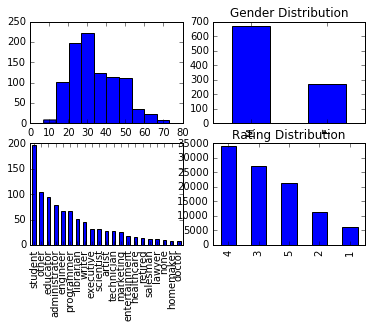

In [8]:
plt.subplot(221)
plt.hist(data_users['age'])
plt.subplot(222)
#plt.bar(data_users['gender'])
data_users['gender'].value_counts().plot(kind='bar', title='Gender Distribution')
plt.subplot(223)
data_users['occupation'].value_counts().plot(kind='bar')
plt.subplot(224)
data_rating['rating'].value_counts().plot(kind='bar', title='Rating Distribution')

In [7]:
if data_rating.isnull() is True:
    print('There are missing records')
else:
    print('No missing records')

No missing records


In [11]:
Number_Ratings = len(data_rating)
print('Count of Ratings given: ',Number_Ratings)
Number_Movies = len(np.unique(data_rating['movie_id']))      
print('Total count of unique movies: ',Number_Movies)
Number_Users = len(np.unique(data_rating['user_id']))
print('Total count of users who rated movies: ',Number_Users)
sparcity = (Number_Ratings)/(Number_Movies*Number_Users)
print ('Sparcity in the rating data is: ',sparcity)

('Count of Ratings given: ', 100000)
('Total count of unique movies: ', 1682)
('Total count of users who rated movies: ', 943)
('Sparcity in the rating data is: ', 0)


#### 1. We see there is no missing values
#### 2. Since, this dataset is being clean for years together we dont see much sparcity in the dataset which is good

## <font color='blue'> Step-3. Data Partition (Train, Validation and Test) </font>
#### 1. Here we will do a Train-Test split using the sklearn library
#### 2. However, if you observe the dataset ml-100k.zip it has numerous data files
#### 3. Readme.txt will well explain what these files signifies
#### 4. In brief, zip file has a consolidated data file with rating details in u.data which has 100000 data in it, which is explored above
#### 5. Movie Lens has already provided a 90-10 split in data which is available as ua.base and ua.test and validation data being ub.base and ub.test
#### 6. For users interested in doing cross fold validation, Movie Lens has split the main u.data into 5 chunk with which we can perform 5-fold cross validation on the data to evaluate our model more robustly.
#### 7. For this project i will be using only user.data for model building

#### <font color='brown'> 70-30 split for train and test data using sklearn </font>

In [20]:
# split the main data frame into 70-30 split for train and test data
data_to_train, data_test = train_test_split(data_rating,train_size=0.7,test_size=0.3,random_state=1)

# split the train data obtained above futher into 75-25 split for train and validation data
data_train, data_validation = train_test_split(data_to_train,train_size=0.75,test_size=0.25,random_state=1)

In [21]:
# lets check the shape of the dataset
print 'shape of train data: ', data_train.shape
print 'shape of Validation data: ', data_validation.shape
print 'shape of test data: ', data_test.shape

shape of train data:  (52500, 4)
shape of Validation data:  (17500, 4)
shape of test data:  (30000, 4)


## <font color='blue'> Step-4. Type casting the dataframe to graphlib data structure sframe  </font>
#### 1. gaphlab is getting popular in data science community 
#### 2. gaphlab is licensed by Turi and i have a student subscription for 1 year which i would like to use in this case study
#### 3. Before we deal with any graphlab methods, it is better to have data in graphlab supported data structure for fast computation
#### 3. gaphlab as a 4 main inbuilt data structure
##### <font color='red'> a. sframe </font>
##### <font color='red'> b. sarray </font>
##### <font color='red'> c. sgraph </font>
##### <font color='red'> d. timeseries </font>
#### 2. For this case study I wish to use sframe data structure with which graph labs computation increase immensely
#### 3. As part of model building and validation, I will record the time taken to build and evaluate the model too

In [22]:
# Type casting from dataframe to sframe
# so that this sframe data object can be directly ised to train a recommender model
data_sframe_train = gl.SFrame(data_train)
data_sframe_validation = gl.SFrame(data_validation)
data_sframe_test = gl.SFrame(data_test)

This non-commercial license of GraphLab Create for academic use is assigned to psathyam@mail.depaul.edu and will expire on November 20, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\prade\AppData\Local\Temp\graphlab_server_1511498030.log.0


In [ ]:
sf_details = pd.DataFrame(columns=['SFrame_Name','Description'])
sf_details['SFrame_Name'] = ['data_sframe_train1','data_sframe_test1','data_sframe_train2','data_sframe_test2']
sf_details['Description'] = ['SFrame of Training data with 70-30 split done manually',
                             'SFrame of Testing data with 70-30 split done manually',
                             'SFrame of Training data with 90-10 split done by Movie Lens',
                             'SFrame of Testing data with 90-10 split done by Movie Lens']
sf_details

In [32]:
data_shape = [data_train.shape, data_validation.shape, data_test.shape]
               
df_details = pd.DataFrame(columns=['DataFrame_Name','SFrame_Name','Description','Shape'])
df_details['DataFrame_Name'] = ['data_train','data_validation','data_test']
df_details['SFrame_Name'] = ['data_sframe_train','data_sframe_validation','data_sframe_test']
df_details['Description'] = ['Training dataset with 70-30 split done on Raw Data', 
                             'Validation dataset with 75-25 split done on Training Data',
                             'Testing dataset with 70-30 split done manually']
df_details['Shape'] = data_shape
df_details

,DataFrame_Name,SFrame_Name,Description,Shape
0,data_train,data_sframe_train,Training dataset with 70-30 split done on Raw ...,"(52500, 4)"
1,data_validation,data_sframe_validation,Validation dataset with 75-25 split done on Tr...,"(17500, 4)"
2,data_test,data_sframe_test,Testing dataset with 70-30 split done manually,"(30000, 4)"


## <font color='blue'> Step-5: Building Popularity Recommender Model </font>
#### 1. Here I will create a model that makes recommendations using item popularity.
#### 2. For this as said above I am going to use the graphlab package built by Turi, I have subscribed for a students license for 1 year
#### 3. graphlab provides few methods for applications like recommender system which I have experimented as part of this case study

#### <font color='brown'> Train the recommender model with training data: </font>
1. I will be using popularity_recommender methods from graphlab module to build this model
2. I will call this my popularity_model
3. I will train my recommender model using data_sframe_train

In [33]:
# create() method in popularity_recommender will create a model that makes recommendations using item popularity.
popularity_model = gl.popularity_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', target='rating')

Recsys training: model = popularity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.378392s

52500 observations to process; with 1571 unique items.

#### 1. I see the computation to be very fast, that is less than a second for 52500 instances

#### <font color='brown'>Generating recommendations from Popularity Recommender trained using training data: </font>

In [34]:
# Get recommendations for first 5 users and print them
# users = range(1,6) specifies user ID of first 5 users
# k=6 specifies top 6 recommendations to be given
popularity_recomm = popularity_model.recommend(users=range(1,6),k=6)
popularity_recomm.print_rows(num_rows=30)

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1462   |  5.0  |  1   |
|    1    |   1122   |  5.0  |  2   |
|    1    |   851    |  5.0  |  3   |
|    1    |   1653   |  5.0  |  4   |
|    1    |   1367   |  5.0  |  5   |
|    1    |   1189   |  5.0  |  6   |
|    2    |   1462   |  5.0  |  1   |
|    2    |   1122   |  5.0  |  2   |
|    2    |   851    |  5.0  |  3   |
|    2    |   1653   |  5.0  |  4   |
|    2    |   1367   |  5.0  |  5   |
|    2    |   1189   |  5.0  |  6   |
|    3    |   1462   |  5.0  |  1   |
|    3    |   1122   |  5.0  |  2   |
|    3    |   851    |  5.0  |  3   |
|    3    |   1653   |  5.0  |  4   |
|    3    |   1367   |  5.0  |  5   |
|    3    |   1189   |  5.0  |  6   |
|    4    |   1462   |  5.0  |  1   |
|    4    |   1122   |  5.0  |  2   |
|    4    |   851    |  5.0  |  3   |
|    4    |   1653   |  5.0  |  4   |
|    4    |   1367   |  5.0  |  5   |
|    4    | 

#### <font color='brown'>Inferring the above results: </font>
##### 1. From above result we see movie_id 1462, 1122, 851, 1653, 1367 and 1189 have been suggested to all users
##### 2. Result clearly shows that there is no personalization or personalized recommendation for each user
##### 3. Reason for why we get repeated movie_id is explored below:

In [37]:
data_train.groupby(by='movie_id')['rating'].mean().sort_values(ascending=False).head(20)

movie_id
1643    5.000000
1367    5.000000
1467    5.000000
1605    5.000000
1293    5.000000
1653    5.000000
1617    5.000000
1189    5.000000
1462    5.000000
1491    5.000000
851     5.000000
1594    5.000000
1201    5.000000
1122    5.000000
1612    5.000000
1429    5.000000
1449    4.750000
408     4.555556
114     4.527778
850     4.500000
Name: rating, dtype: float64

#### 1. With above result I can infer that all the recommended movies 1462, 1122, 851, 1653, 1367 and 1189 have an average rating of 5
#### 2. There are even other movie_id which has rating 5 and are not in above suggestion result, this is because we have restricted to print the information of only top 6 recommendation
#### 3. With this I can infer that all the users who watched these movies always gave a top rating. Thus we can see that our popularity system suggested the same and works as expected. 
#### However, can we trust this result? Because, as said above we see no personolization in result. These are just recommendation based on item popularity. 
#### 5. Also can we just accept this recommender model as it is? No, model needs to be evaluated. I’ll analyze it in detail later.

#### <font color='brown'>Inference from Popularity Recommender Model: </font>
##### 1. Popularity model produce results based on items popularity 
##### 2. Those movies with rating 5 are suggested to all the user
##### 3. Thus, it doesnt take users interest into account and doesnt do any personalization based on user interest
##### 4. I will try to deal with this personalization concern first and later evaluate all models in model evaluation as we go forward.

## <font color='blue'> Step-6. Building a collaborative Recommender - User Based Recommender Model </font>

### <font color='brown'>Step-6.1: Training the model with Training dataset: </font>

In [40]:
#Train Model
# I prefered to used factorization_recommender from graphlab to build this recommendation model
user_sim_model = gl.factorization_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', target='rating')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.094107s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 52500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.622194                                 |

| 4       | 0.130208          | 0.576243                                 |

| 5       | 0.0651042         | 0.699342                                 |

| 6       | 0.0325521         | 0.838311                                 |

| 7       | 0.016276          | 0.945986                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.576243                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.002ms      | 1.26907           | 1.12653               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.102ms     | 2.5181            | 1.58685               | 0.130208    |

| 2       | 198.223ms    | 1.15629           | 1.07531               | 0.130208    |

| 3       | 303.342ms    | 1.03926           | 1.01944               | 0.130208    |

| 4       | 360.406ms    | 0.997402          | 0.9987                | 0.130208    |

| 5       | 487.548ms    | 0.979792          | 0.989844              | 0.130208    |

| 6       | 621.7ms      | 0.967461          | 0.983596              | 0.130208    |

| 11      | 944.064ms    | 0.918228          | 0.958241              | 0.130208    |

| 25      | 1.87s        | 0.878384          | 0.937221              | 0.130208    |

| 50      | 3.49s        | 0.852163          | 0.923126              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.809036

Final training RMSE: 0.899464

#### 1. Above model produce a RMSE of 0.8994
#### 2. This RMSE is much lesser when compare to the RMSE obtained from Linear model which was 1.207
#### 3. If you notice above, model is bilt with L2 Regularization on Factors = 1e-008   
#### 4. Let me try to fine tune this regularization factor to see if i can improve the RMSE result

### <font color='brown'>Step-6.2: Validating the model with Validation dataset:  </font>
#### Here I will try to check if there is any improvement in RMSE value with change in Regularization parameter using validation dataset
#### regularization : float, optional
#### Regularization for interaction terms. The type of regularization is L2.
#### Default: 1e-8; a typical range for this parameter is between 1e-12 and 1. Let us try one by one to fit the best parameter

#### Default Model

In [47]:
# choosing regularization=1e-07 for model-1 with data_sframe_train
user_sim_model_0 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-08)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.030032s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.4554                                   |

| 4       | 0.130208          | 0.281378                                 |

| 5       | 0.0651042         | 0.730031                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.281378                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1ms          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 41.047ms     | 1.30886           | 1.14405               | 0.130208    |

| 2       | 70.078ms     | 0.934178          | 0.966527              | 0.130208    |

| 3       | 127.146ms    | 0.832198          | 0.912247              | 0.130208    |

| 4       | 165.186ms    | 0.777462          | 0.881736              | 0.130208    |

| 5       | 186.21ms     | 0.737075          | 0.858528              | 0.130208    |

| 6       | 226.254ms    | 0.708731          | 0.841858              | 0.130208    |

| 11      | 423.477ms    | 0.611044          | 0.781688              | 0.130208    |

| 50      | 1.45s        | 0.327822          | 0.572539              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.303319

Final training RMSE: 0.550726

#### Model-1

In [48]:
# choosing regularization=1e-07 for model-1 with data_sframe_train
user_sim_model_1 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-07)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.028032s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-007   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.486478                                 |

| 4       | 0.130208          | 0.333569                                 |

| 5       | 0.0651042         | 0.722977                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.333569                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 30.034ms     | 1.3449            | 1.15969               | 0.130208    |

| 2       | 54.061ms     | 0.89446           | 0.945741              | 0.130208    |

| 3       | 83.095ms     | 0.803252          | 0.896221              | 0.130208    |

| 4       | 119.136ms    | 0.760458          | 0.872016              | 0.130208    |

| 5       | 153.173ms    | 0.722483          | 0.849959              | 0.130208    |

| 6       | 184.21ms     | 0.690123          | 0.8307                | 0.130208    |

| 11      | 346.39ms     | 0.5921            | 0.769422              | 0.130208    |

| 50      | 1.30s        | 0.291475          | 0.539659              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.268806

Final training RMSE: 0.51823

#### Model-2

In [49]:
# choosing regularization=1e-06 for model-2 with data_sframe_train
user_sim_model_2 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-06)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.029032s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.316705                                 |

| 4       | 0.130208          | 0.333055                                 |

| 5       | 0.0651042         | 0.712381                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 0.316705                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 94.107ms     | DIVERGED          | DIVERGED              | 0.260417    |

| RESET   | 105.12ms     | 1.26526           | 1.12484               |             |

| 1       | 157.179ms    | 1.19467           | 1.09285               | 0.130208    |

| 2       | 206.233ms    | 0.849923          | 0.921657              | 0.130208    |

| 3       | 251.288ms    | 0.766255          | 0.875018              | 0.130208    |

| 4       | 277.312ms    | 0.703094          | 0.838062              | 0.130208    |

| 5       | 326.37ms     | 0.650225          | 0.805805              | 0.130208    |

| 6       | 363.41ms     | 0.606152          | 0.777879              | 0.130208    |

| 11      | 526.594ms    | 0.438461          | 0.660877              | 0.130208    |

| 24      | 876.99ms     | 0.274073          | 0.520991              | 0.130208    |

| 49      | 1.54s        | 0.206224          | 0.450345              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.186842

Final training RMSE: 0.428266

#### Model-3

In [50]:
# choosing regularization=1e-05 for model-3 with data_sframe_train
user_sim_model_3 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-05)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.035042s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-005   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.670934                                 |

| 4       | 0.130208          | 0.295602                                 |

| 5       | 0.0651042         | 0.690095                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.295602                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.061ms     | 1.35247           | 1.16173               | 0.130208    |

| 2       | 79.091ms     | 0.89427           | 0.943863              | 0.130208    |

| 3       | 116.132ms    | 0.806743          | 0.89593               | 0.130208    |

| 4       | 151.172ms    | 0.755945          | 0.866706              | 0.130208    |

| 5       | 193.228ms    | 0.720721          | 0.845737              | 0.130208    |

| 6       | 263.296ms    | 0.693093          | 0.828837              | 0.130208    |

| 11      | 409.462ms    | 0.598688          | 0.767901              | 0.130208    |

| 50      | 1.49s        | 0.429534          | 0.641661              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.398736

Final training RMSE: 0.617196

#### Model-4

In [51]:
# choosing regularization=1e-04 for model-4 with data_sframe_train
user_sim_model_3 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-04)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.028029s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.46062                                  |

| 4       | 0.130208          | 0.534695                                 |

| 5       | 0.0651042         | 0.732837                                 |

| 6       | 0.0325521         | 0.886922                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.260417          | 0.46062                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 44.03ms      | 2.05845           | 1.42009               | 0.260417    |

| 2       | 71.062ms     | 0.948065          | 0.950021              | 0.260417    |

| 3       | 93.084ms     | 0.833206          | 0.882535              | 0.260417    |

| 4       | 126.124ms    | 0.785116          | 0.84862               | 0.260417    |

| 5       | 166.167ms    | 0.749511          | 0.820478              | 0.260417    |

| 6       | 189.193ms    | 0.718685          | 0.794519              | 0.260417    |

| 11      | 343.367ms    | 0.600732          | 0.679436              | 0.260417    |

| 50      | 1.26s        | 0.46061           | 0.456435              | 0.260417    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.44085

Final training RMSE: 0.43425

#### Model-5

In [52]:
# choosing regularization=1e-03 for model-5 with data_sframe_train
user_sim_model_3 = gl.factorization_recommender.create(data_sframe_validation, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-03)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 17500 observations with 937 users and 1389 items.

Data prepared in: 0.034038s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 17500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.20159           | Not Viable                               |

| 1       | 1.0504            | 0.994068                                 |

| 2       | 0.525199          | 0.902037                                 |

| 3       | 0.262599          | 0.840481                                 |

| 4       | 0.1313            | 0.841389                                 |

| 5       | 0.0656498         | 0.906083                                 |

| 6       | 0.0328249         | 0.985205                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.262599          | 0.840481                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26522           | 1.12482               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 37.041ms     | 1.41809           | 1.1274                | 0.262599    |

| 2       | 62.068ms     | 0.940078          | 0.931578              | 0.262599    |

| 3       | 88.098ms     | 0.871426          | 0.903412              | 0.262599    |

| 4       | 136.154ms    | 0.846301          | 0.893064              | 0.262599    |

| 5       | 178.201ms    | 0.831956          | 0.886894              | 0.262599    |

| 6       | 206.233ms    | 0.825158          | 0.88387               | 0.262599    |

| 11      | 365.412ms    | 0.799644          | 0.87366               | 0.262599    |

| 50      | 1.28s        | 0.790163          | 0.852787              | 0.262599    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.797598

Final training RMSE: 0.857135

In [53]:
# Model evaluation on the training set
model_results_1 = pd.DataFrame(columns=['Model_Name','regularization','RMSE'])
model_results_1['Model_Name'] = ['Model-0','Model-1','Model-2','Model-3','Model-4','Model-5']
model_results_1['regularization'] = ['1e-08','1e-07','1e-06','1e-05','1e-04','1e-03']
model_results_1['RMSE'] = ['0.550726', '0.51823', '0.428266', '0.617196', '0.43425', '0.857135']
model_results_1

,Model_Name,regularization,RMSE
0,Model-0,1e-08,0.550726
1,Model-1,1e-07,0.51823
2,Model-2,1e-06,0.428266
3,Model-3,1e-05,0.617196
4,Model-4,1e-04,0.43425
5,Model-5,1e-03,0.857135


#### 1. From above result it is very evident that, model-2 gives low RMSE of 0.428266 when regularization parameter is 1e-06
#### 2. Thus, I will use model-2 as a final model to train the model with training dataset instead of validation dataset

In [54]:
# final model being trained with training data and regularization parameter = 1e-06
user_sim_model_final = gl.factorization_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-06)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.088097s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 52500 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.608362                                 |

| 4       | 0.130208          | 0.492871                                 |

| 5       | 0.0651042         | 0.726871                                 |

| 6       | 0.0325521         | 0.8703                                   |

| 7       | 0.016276          | 0.961131                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.492871                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26907           | 1.12653               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 99.112ms     | 1.73955           | 1.31887               | 0.130208    |

| 2       | 166.187ms    | 1.03768           | 1.01861               | 0.130208    |

| 3       | 243.277ms    | 0.970224          | 0.984943              | 0.130208    |

| 4       | 323.366ms    | 0.945403          | 0.972261              | 0.130208    |

| 5       | 400.452ms    | 0.932963          | 0.965842              | 0.130208    |

| 6       | 463.523ms    | 0.925955          | 0.962207              | 0.130208    |

| 11      | 727.822ms    | 0.880514          | 0.938295              | 0.130208    |

| 25      | 1.57s        | 0.842258          | 0.917672              | 0.130208    |

| 50      | 3.10s        | 0.813036          | 0.90158               | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.77653

Final training RMSE: 0.881102

In [57]:
# Make Recommendations with model trianed using training data:
# I will print top 6 recommendation for 5 users
user_sim_recomm_train = user_sim_model_final.recommend(users=range(1,3),k=3)
user_sim_recomm_train.print_rows(num_rows=9)

+---------+----------+---------------+------+
| user_id | movie_id |     score     | rank |
+---------+----------+---------------+------+
|    1    |   408    |  4.6222564055 |  1   |
|    1    |   483    |  4.5625470654 |  2   |
|    1    |   318    | 4.52536337086 |  3   |
|    2    |   114    | 4.74621496265 |  1   |
|    2    |   408    | 4.73774335775 |  2   |
|    2    |   483    | 4.66637602131 |  3   |
+---------+----------+---------------+------+
[6 rows x 4 columns]



#### 1. we see some improvement in our final model after validation
#### 2. Before validation I got a RMSE of 0.89 and after validation i got an RMSE of 0.88 which is good 
#### 3. Also, I can observe that there is some personalization in scores for each user

### <font color='brown'> Step-6.3: User Based Collaborative Filtering Final Model testing with test data: </font>

In [58]:
user_sim_model_final_test = gl.factorization_recommender.create(data_sframe_test, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-06)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 30000 observations with 943 users and 1500 items.

Data prepared in: 0.051057s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 30000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.610283                                 |

| 4       | 0.130208          | 0.31686                                  |

| 5       | 0.0651042         | 0.677028                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.31686                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26481           | 1.12464               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.073ms     | 2.19988           | 1.48316               | 0.130208    |

| 2       | 125.128ms    | 1.11016           | 1.05359               | 0.130208    |

| 3       | 206.22ms     | 0.976278          | 0.988017              | 0.130208    |

| 4       | 239.257ms    | 0.937454          | 0.96817               | 0.130208    |

| 5       | 292.317ms    | 0.9189            | 0.95854               | 0.130208    |

| 6       | 360.395ms    | 0.900525          | 0.948907              | 0.130208    |

| 11      | 553.613ms    | 0.856173          | 0.925241              | 0.130208    |

| 25      | 1.04s        | 0.815676          | 0.903088              | 0.130208    |

| 50      | 1.90s        | 0.78728           | 0.887215              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.742068

Final training RMSE: 0.861359

#### 1. RMSE we obtain from train, validation and test seems closer that is 0.89, 0.88 and 0.86
#### 2. With this I can infer that i am not over fitting my User Based collaborative recommendation model

### <font color='brown'> Step-6.4: Recommendation based on User Based Collaborative Filtering: </font>

##### Recommendation from model trained with Testing Data:

In [60]:
# Make Recommendations with model trianed using training data:
# I will print top 6 recommendation for 5 users
user_sim_recomm_2 = user_sim_model_final_test.recommend(users=range(1,6),k=6)
user_sim_recomm_2.print_rows(num_rows=30)

+---------+----------+---------------+------+
| user_id | movie_id |     score     | rank |
+---------+----------+---------------+------+
|    1    |   922    | 4.26032714744 |  1   |
|    1    |   313    | 4.24717323308 |  2   |
|    1    |   963    | 4.21449067712 |  3   |
|    1    |   190    | 4.19517746953 |  4   |
|    1    |   921    | 4.18740516541 |  5   |
|    1    |   169    |  4.1470121859 |  6   |
|    2    |   922    | 4.77391810763 |  1   |
|    2    |   313    | 4.76257140691 |  2   |
|    2    |    64    | 4.75562609745 |  3   |
|    2    |   963    |  4.7356186217 |  4   |
|    2    |   190    | 4.70762745094 |  5   |
|    2    |   921    | 4.70239903144 |  6   |
|    3    |   922    | 4.74458507391 |  1   |
|    3    |   313    | 4.73629232345 |  2   |
|    3    |    64    |  4.710909497  |  3   |
|    3    |   963    | 4.69731578179 |  4   |
|    3    |   190    | 4.67862708809 |  5   |
|    3    |   921    | 4.67227857805 |  6   |
|    4    |   922    | 4.793141285

### <font color='brown'>Step-6.5: Inference from Movies recommended above: </font>
#### 1. From above recommended result we see that the recommendation of movie_id differs slightly from user to user
#### 2. Scores given again each user and movie is also different
#### 2. This was not the case with popularity recommendation model
#### 3. Looking at the above results, we can make a naive assumption that User Based recommendation model provide much better recommendation compare to popularity recommendation model
#### 4. These are not final recommendation because, I am yet to evaluate the model with test dataset and then produce my final recommendation

## <font color='blue'> Step-7. Building a collaborative Recommender - Item Based Recommender Model </font>

In [61]:
# we will use the same dataset 
df_details

,DataFrame_Name,SFrame_Name,Description,Shape
0,data_train,data_sframe_train,Training dataset with 70-30 split done on Raw ...,"(52500, 4)"
1,data_validation,data_sframe_validation,Validation dataset with 75-25 split done on Tr...,"(17500, 4)"
2,data_test,data_sframe_test,Testing dataset with 70-30 split done manually,"(30000, 4)"


### <font color='brown'>Step-7.1: Training the model with different similarity metrics: </font>
#### 1. For distance measure / similarity metrics we have 3 types supported by graphlab
#### 2. {'jaccard', 'cosine', 'pearson'}

#### Model-1:

In [77]:
#### Model-1: Training using pearson similarity metric
item_sim_model_1 = gl.item_similarity_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', 
                                                             target='rating', similarity_type='pearson')

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.145164s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.004ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 15.017ms                            | 0                | 2               |

| 219.249ms                           | 100              | 1571            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.256292s

#### Model-2:

In [78]:
# for this model 2 let me trywith jaccard similarity metric
item_sim_model_2 = gl.item_similarity_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', 
                                                             target='rating', similarity_type='jaccard')

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.186211s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.01ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 57.065ms                            | 0                | 2               |

| 158.178ms                           | 100              | 1571            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.21124s

#### Model-3:

In [105]:
# for this model 3 let me trywith cosine similarity metric
item_sim_model_3 = gl.item_similarity_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', 
                                                             target='rating', similarity_type='cosine',only_top_k=100)

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.229257s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.004ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.031ms                            | 0                | 1               |

| 161.202ms                           | 100              | 1571            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.185209s

### <font color='brown'>Step-7.2: Evaluating Models Built above: </font>
#### 1. For item based, it is more precise to evaluate a model looking at its precision and recall measure 
#### 2. I will do the same using graphlab below
#### 3. I will evaluate this model with Validation dataset in order to find the optimal cutoff for the nearest neighbors

In [80]:
item_sim_model_1.evaluate_precision_recall(data_sframe_validation)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 16866
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    1    |   1    |    0.0    |  0.0   |   44  |
 |    1    |   2    |    0.0    |  0.0   |   44  |
 |    1    |   3    |    0.0    |  0.0   |   44  |
 |    1    |   4    |    0.0    |  0.0   |   44  |
 |    1    |   5    |    0.0    |  0.0   |   44  |
 |    1    |   6    |    0.0    |  0.0   |   44  |
 |    1    |   7    |    0.0    |  0.0   |   44  |
 |    1    |   8    |    0.0    |  0.0   |   44  |
 |    1    |   9    |    0.0    |  0.0   |   44  |
 |    1    |   10   |    0.0    |  0.0   |   44  |
 +---------+--------+-----------+--------+-------+
 [16866 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and colum

In [81]:
item_sim_model_2.evaluate_precision_recall(data_sframe_validation)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 16866
 
 Data:
 +---------+--------+----------------+-----------------+-------+
 | user_id | cutoff |   precision    |      recall     | count |
 +---------+--------+----------------+-----------------+-------+
 |    1    |   1    |      0.0       |       0.0       |   44  |
 |    1    |   2    |      0.0       |       0.0       |   44  |
 |    1    |   3    | 0.333333333333 | 0.0227272727273 |   44  |
 |    1    |   4    |      0.25      | 0.0227272727273 |   44  |
 |    1    |   5    |      0.2       | 0.0227272727273 |   44  |
 |    1    |   6    | 0.166666666667 | 0.0227272727273 |   44  |
 |    1    |   7    | 0.142857142857 | 0.0227272727273 |   44  |
 |    1    |   8    |     0.125      | 0.0227272727273 |   44  |
 |    1    |   9    | 0.111111111111 | 0.0227272727273 |   44  |
 |    1    |   10   |      0.1       | 0.0227272727273 |   44  |
 +---------+--------+

In [106]:
item_sim_model_3.evaluate_precision_recall(data_sframe_validation)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 16866
 
 Data:
 +---------+--------+----------------+-----------------+-------+
 | user_id | cutoff |   precision    |      recall     | count |
 +---------+--------+----------------+-----------------+-------+
 |    1    |   1    |      1.0       | 0.0227272727273 |   44  |
 |    1    |   2    |      0.5       | 0.0227272727273 |   44  |
 |    1    |   3    | 0.333333333333 | 0.0227272727273 |   44  |
 |    1    |   4    |      0.25      | 0.0227272727273 |   44  |
 |    1    |   5    |      0.2       | 0.0227272727273 |   44  |
 |    1    |   6    | 0.166666666667 | 0.0227272727273 |   44  |
 |    1    |   7    | 0.142857142857 | 0.0227272727273 |   44  |
 |    1    |   8    |      0.25      | 0.0454545454545 |   44  |
 |    1    |   9    | 0.222222222222 | 0.0454545454545 |   44  |
 |    1    |   10   |      0.3       | 0.0681818181818 |   44  |
 +---------+--------+

#### 1. From above result it is clearly evident that model-1 built using 'pearson' similarity metric fails miserably
#### 2. Even, model-2 built using 'jaccard' doesnt perform well, but compare to model-1 it is better
#### 3. Even model-3 built using 'cosine' doesnt perform well, but comparitively better than model-1 and model-2
#### 4. Thus i will choose model-3 as my final model for further exploration.
#### 5. I played around with different values for parameter 'only_top_k' in item_similarity_recommender() method
#### 6. It looks for k nearest neighbors and optimum one was 100 neighbours which produced some decent precision and recall value

#### Final Model built using cosine similarity with testing data:

In [108]:
item_sim_model_final = gl.item_similarity_recommender.create(data_sframe_test, user_id='user_id', item_id='movie_id', 
                                                             target='rating', similarity_type='cosine',only_top_k=100)

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 30000 observations with 943 users and 1500 items.

Data prepared in: 0.240271s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 38.044ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 46.058ms                            | 0                | 0               |

| 152.174ms                           | 100              | 1500            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.162185s

#### <font color='brown'>Step-7.3: Recommendation based on Item Based Collaborative Filtering:</font>

#### Recommendation based on train data:

In [109]:
#Make Recommendations:
item_sim_recomm_1 = item_sim_model_3.recommend(users=range(1,6),k=6)
item_sim_recomm_1.print_rows(num_rows=30)

+---------+----------+----------------+------+
| user_id | movie_id |     score      | rank |
+---------+----------+----------------+------+
|    1    |    69    | 0.598578958887 |  1   |
|    1    |   174    | 0.595588119879 |  2   |
|    1    |   202    | 0.577328914241 |  3   |
|    1    |   403    | 0.562035409963 |  4   |
|    1    |   144    | 0.52899400747  |  5   |
|    1    |   186    | 0.52192829039  |  6   |
|    2    |   100    | 0.619842488851 |  1   |
|    2    |    9     | 0.55391170936  |  2   |
|    2    |   117    | 0.551121243409 |  3   |
|    2    |    7     | 0.540313710059 |  4   |
|    2    |   127    | 0.526376754045 |  5   |
|    2    |   405    | 0.513156714184 |  6   |
|    3    |   879    | 0.380774579114 |  1   |
|    3    |   288    | 0.360899445083 |  2   |
|    3    |   313    | 0.332549204429 |  3   |
|    3    |   268    | 0.329984443055 |  4   |
|    3    |   748    | 0.32180487944  |  5   |
|    3    |   326    | 0.313141362535 |  6   |
|    4    |  

#### Recommendation Based on Test Data:

In [110]:
#Make Recommendations:
item_sim_recomm_2 = item_sim_model_final.recommend(users=range(1,6),k=6)
item_sim_recomm_2.print_rows(num_rows=30)

+---------+----------+----------------+------+
| user_id | movie_id |     score      | rank |
+---------+----------+----------------+------+
|    1    |    69    | 0.260221560554 |  1   |
|    1    |   210    | 0.254621682371 |  2   |
|    1    |   209    | 0.241089733636 |  3   |
|    1    |   173    | 0.235210263148 |  4   |
|    1    |   172    | 0.233835691359 |  5   |
|    1    |   204    | 0.220094046215 |  6   |
|    2    |   286    | 0.371807640791 |  1   |
|    2    |    50    | 0.363123756647 |  2   |
|    2    |   237    | 0.339358621836 |  3   |
|    2    |    13    | 0.331299710274 |  4   |
|    2    |   111    | 0.287866714597 |  5   |
|    2    |    7     | 0.275874319673 |  6   |
|    3    |   302    | 0.254992799325 |  1   |
|    3    |   908    | 0.214484751225 |  2   |
|    3    |   991    | 0.210522321138 |  3   |
|    3    |   1625   | 0.188660973852 |  4   |
|    3    |   1624   | 0.188660973852 |  5   |
|    3    |   691    | 0.183499802243 |  6   |
|    4    |  

## <font color='blue'> Step-8: Testing and Comparing all selected recommender models using Test Data </font>
#### We will compare all final models built and selected as most optimised of each recommender model trained using the large set of training data.

In [111]:
model_performance = gl.compare(data_sframe_test, [popularity_model, user_sim_model_final, item_sim_model_3])
gl.canvas.set_target('ipynb')
gl.show_comparison(model_performance,[popularity_model, user_sim_model_final, item_sim_model_3])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    | 0.00318133616119 | 5.51392020631e-05 |
|   2    | 0.00265111346766 | 7.43100370373e-05 |
|   3    | 0.00176740897844 | 7.43100370373e-05 |
|   4    | 0.00132555673383 | 7.43100370373e-05 |
|   5    | 0.00148462354189 | 0.000144262223973 |
|   6    | 0.00176740897844 | 0.000270258494273 |
|   7    | 0.00166641417967 | 0.000303397412618 |
|   8    | 0.00172322375398 | 0.000348586846726 |
|   9    | 0.00164958171321 | 0.000381725765072 |
|   10   | 0.00180275715801 | 0.000543976578518 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-------------

#### 1. From above result I can infer that Item based collaborative filetering model performs better than popularity and User based model as it precision and recall is comparitively high.
#### 2. On absolute level, I see even Item based collaborative filtering model is behaving not that efficiently
#### 3. All models built above are far from being used as a useful recommendation model
#### 4. However, with this experiment i understood how a recommendation system is built and how models are built and validated while building a recommendation model.
#### 5. My next reseach work will be on working on the core algorithm instead of using graphlab and design my own implementation of recommender model using python.
#### 6. I wil also try on more sophisticated algorithm in graphlab to build much more accuracy wrt precision & recall

## <font color='blue'> Step-9: Final Model Proposed: </font>

In [112]:
# creating the SFrame dataset for whole rating dataset
data_sframe_rating = gl.SFrame(data_rating)

In [129]:
# building the final user based recommender model using the complete data available
final_model_user =  gl.factorization_recommender.create(data_sframe_rating, user_id='user_id', item_id='movie_id', 
                                                             target='rating',regularization=1e-06)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 100000 observations with 943 users and 1682 items.

Data prepared in: 0.546617s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12500 / 100000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.576839                                 |

| 4       | 0.130208          | 0.313941                                 |

| 5       | 0.0651042         | 0.704698                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.313941                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.002ms      | 1.26711           | 1.12566               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 109.122ms    | 1.87237           | 1.36829               | 0.130208    |

| 2       | 240.283ms    | 1.05297           | 1.02608               | 0.130208    |

| 3       | 388.437ms    | 0.98114           | 0.990461              | 0.130208    |

| 4       | 507.572ms    | 0.956393          | 0.977889              | 0.130208    |

| 5       | 600.677ms    | 0.942496          | 0.970758              | 0.130208    |

| 6       | 709.8ms      | 0.929944          | 0.96427               | 0.130208    |

| 10      | 1.07s        | 0.904276          | 0.950867              | 0.130208    |

| 11      | 1.21s        | 0.901517          | 0.949415              | 0.130208    |

| 20      | 2.11s        | 0.880826          | 0.938451              | 0.130208    |

| 30      | 2.99s        | 0.867313          | 0.93122               | 0.130208    |

| 40      | 3.78s        | 0.857446          | 0.925901              | 0.130208    |

| 50      | 4.54s        | 0.850103          | 0.92192               | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.825405

Final training RMSE: 0.908427

In [128]:
# building the final item based recommender model using the complete data available
final_model_item = gl.item_similarity_recommender.create(data_sframe_train, user_id='user_id', item_id='movie_id', 
                                                             target='rating', similarity_type='cosine',only_top_k=100)

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 52500 observations with 943 users and 1571 items.

Data prepared in: 0.486549s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 33.037ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 41.048ms                            | 0                | 1               |

| 186.208ms                           | 100              | 1571            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.245277s

### <font color='blue'> Step-10: Getting Top-K Recommendations </font>

In [131]:
# I will print top 6 recommendation for 5 users based on user based model
final_recommendation_user = final_model_user.recommend(users=range(1,6),k=6)
final_recommendation_user.print_rows(num_rows=30)

+---------+----------+---------------+------+
| user_id | movie_id |     score     | rank |
+---------+----------+---------------+------+
|    1    |   408    | 4.52468324743 |  1   |
|    1    |   318    | 4.50159300758 |  2   |
|    1    |   483    | 4.48533927287 |  3   |
|    1    |   603    | 4.39534885982 |  4   |
|    1    |   313    | 4.39370681985 |  5   |
|    1    |   513    | 4.37869729555 |  6   |
|    2    |   408    | 4.73541305103 |  1   |
|    2    |   483    | 4.69743788765 |  2   |
|    2    |   169    | 4.69059014238 |  3   |
|    2    |   318    | 4.67600079287 |  4   |
|    2    |   114    | 4.66090393065 |  5   |
|    2    |    64    | 4.64581253577 |  6   |
|    3    |   408    | 4.65449810691 |  1   |
|    3    |   169    | 4.62639704008 |  2   |
|    3    |   483    | 4.61986709362 |  3   |
|    3    |   114    | 4.59498115896 |  4   |
|    3    |   603    |  4.5186661136 |  5   |
|    3    |   513    |  4.4999635358 |  6   |
|    4    |   408    | 4.742677996

#### 1. We see the final recommendation is quite personalized based on similar user score
#### 2. For e.g. from above result I can observe user-2 and user-4 are closely matched
#### 2. If you look at user-2, his top 6 movie choices as per rating scores are 408, 483, 169, 318, 114, 64
#### 3. Similarly, if you look at user-4 his top 6 movie choices as per rating scores are 408, 483, 318, 169, 64, 272
#### 4. Thus, based on item, movie_id 408 which has a score of 4.735 for user2 and 4.74 for user4 is a close match
#### 5. Similarly, movie_id 483 which has a score of 4.697 for user2 and 4.70 for user4 is a close match based on this model

In [132]:
# I will print top 6 recommendation for 5 users based on item based model
final_recommendation_item = final_model_item.recommend(users=range(1,6),k=6)
final_recommendation_item.print_rows(num_rows=30)

+---------+----------+----------------+------+
| user_id | movie_id |     score      | rank |
+---------+----------+----------------+------+
|    1    |    69    | 0.623025725966 |  1   |
|    1    |   168    | 0.611371039528 |  2   |
|    1    |   174    | 0.609594366322 |  3   |
|    1    |   202    | 0.597419989844 |  4   |
|    1    |   403    | 0.565831058238 |  5   |
|    1    |   186    | 0.539653516387 |  6   |
|    2    |   100    | 0.619842488851 |  1   |
|    2    |    7     | 0.560542623912 |  2   |
|    2    |    9     | 0.557211975966 |  3   |
|    2    |   127    | 0.527117075665 |  4   |
|    2    |   117    | 0.526377865246 |  5   |
|    2    |    1     | 0.515682446105 |  6   |
|    3    |   288    | 0.360158989827 |  1   |
|    3    |   879    | 0.335134435031 |  2   |
|    3    |   748    | 0.32180487944  |  3   |
|    3    |   313    | 0.315352403455 |  4   |
|    3    |   268    | 0.310082372692 |  5   |
|    3    |   307    | 0.302422275146 |  6   |
|    4    |  

#### 1. We see the final recommendation produced by item based model is completely different compare to user based model
#### 2. Observe the movies recommended for user-1 and user-5
#### 3. Movies liked by user-1 are 69, 168, 174, 202, 403, 186
#### 4. Movies liked by user-5 are 403, 174, 204, 202, 195, 82
#### 5. Thus, if you look at movie_id 403 the score for user1 is 0.565 and user5 is 0.570 is a close match
#### 6. Simlarly movies_id 202 and 174 are close match between user1 and user5 based on item similarity

## <font color='blue'> Conclusion </font>
#### 1. I have experimented a naive approach of building a recommender model using graphlab
#### 2. I see for the given dataset with this naive approach item based modelling behaved with cosine similarity metric and user based model with regualized parameter = 1e-06 behaved quite decent. However, I cannot say it performs recommendation well.
#### 3. Also, item based and user based collaborative filtering give some personalized recommendation when compare to other user based collaborative filtering
#### 4. Also, RMSE value generated from final user based model is 0.908427 which is comparitively less than simple regression model which was 1.2
#### 5. Though its not a quite happy RMSE value to accept, i can feel little happy with the improvement done over linear regression model.
#### 6. This experiment shows that Collaborative Recommendation model is the quite efficient model for such kind product recommendations.
#### 7. While popularity based recommendation are not quite useful for product recommendation. However, can be used in application like news apps, tweet apps, etc., 

## <font color='blue'> Scope of Improvement: </font>
#### 1. All models built above are far from being used as a useful recommendation model
#### 2. However, with this experiment i understood how a recommendation system is built and how models are built and validated while building a recommendation model.
#### 3. My next reseach work will be on working on the core algorithm instead of using graphlab and design my own implementation of recommender model using python.
#### 4. I wil also try on more sophisticated algorithms like ranking_factorization_recommender() in graphlab to build much more accuracy wrt precision & recall

## <font color='red'>      End of the Book!!!   </font>